### Setup

Below setup code is mainly from the ConvolutionalVAE notebook from week 4

In [1]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers.legacy import Adam

from keras.layers import Lambda, Input, Dense
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.layers import Reshape, Flatten, BatchNormalization, Activation

from keras.models import Model
from keras.losses import mse, binary_crossentropy

from keras import backend as K
from keras import optimizers

### Importing datasets

Import the villagers images dataset

Import the villagers information dataset

In [2]:
directory = "villagers"

img_files = []
img_files += [os.path.join(directory, img) for img in os.listdir(directory)]

#print(img_files)

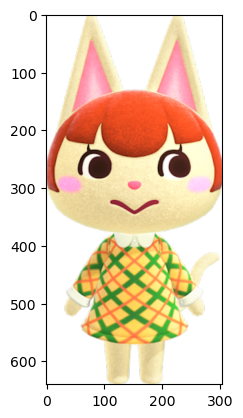

In [3]:
img = plt.imread(img_files[88])
plt.imshow(img)

### Processing of data

-ChatGPT help

In [4]:
# Resize the images
villagers_imgs = []
height = 640
width = 400

for file in img_files:
    
    #skip bc of weird file
    if(file==(directory + "/.DS_Store")):
        continue
    
    #plt.figure()
    img = plt.imread(file)
    img = cv2.resize(img, (width, height))
    #print(img.shape)
    #plt.imshow(img)
    #plt.plot()
    
    villagers_imgs.append(img)

villagers_array = np.array(villagers_imgs)

### Creating train and test sets 



(313, 640, 400, 4)
(79, 640, 400, 4)


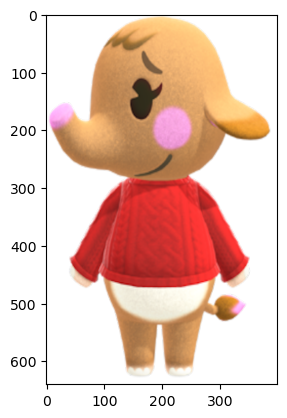

In [5]:
X_train, X_test = train_test_split(villagers_array, test_size=0.2)

print(X_train.shape)
print(X_test.shape)

plt.imshow(X_test[1])


In [6]:
#X_train = X_train.astype('float32') / 255.
#X_test = X_test.astype('float32') / 255.

print(X_train.shape)
print(X_test.shape)

X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(X_train.shape)
print(X_test.shape)

(313, 640, 400, 4)
(79, 640, 400, 4)
(313, 1024000)
(79, 1024000)


### Building a simple autoencoder as a start

Using this tutorial from keras "Let's build the simplest possible autoencoder": https://blog.keras.io/building-autoencoders-in-keras.html

In [7]:
encoding_dim = 64
#input_shape = (640, 400, 4)
input_shape=(1024000,)

epochs = 50
batch_size = 64

inputs = Input(shape=input_shape)

encoded = Dense(encoding_dim, activation='relu')(inputs)
decoded = Dense(input_shape[0], activation='sigmoid')(encoded)

# input -> reconstruction 
autoencoder = Model(inputs, decoded)
print(decoded.shape)

# Encoder
# input -> encoded representation
encoder = Model(inputs, encoded)

# Decoder
encoded_input = Input(shape=encoding_dim)

# last layer of autoencoder model
decoder_layer = autoencoder.layers[-1]

# Create decoder model
# encoded rep -> reconstruction 
decoder = Model(encoded_input, decoder_layer(encoded_input))

# Compilation
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
print(autoencoder.summary())

# Train
autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, 
                shuffle=True, validation_data=(X_test, X_test))


Metal device set to: Apple M1 Max
(None, 1024000)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024000)]         0         
                                                                 
 dense (Dense)               (None, 64)                65536064  
                                                                 
 dense_1 (Dense)             (None, 1024000)           66560000  
                                                                 
Total params: 132,096,064
Trainable params: 132,096,064
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50


/Users/evahayek/miniforge3/envs/coding3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2023-06-14 17:16:36.861805: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5/5 [==============================] - 2s 304ms/step - loss: 0.6541 - val_loss: 0.5674
Epoch 2/50
5/5 [==============================] - 1s 209ms/step - loss: 0.5402 - val_loss: 0.5223
Epoch 3/50
5/5 [==============================] - 1s 205ms/step - loss: 0.5147 - val_loss: 0.5104
Epoch 4/50
5/5 [==============================] - 1s 205ms/step - loss: 0.5089 - val_loss: 0.5054
Epoch 5/50
5/5 [==============================] - 1s 202ms/step - loss: 0.5040 - val_loss: 0.4993
Epoch 6/50
5/5 [==============================] - 1s 202ms/step - loss: 0.4986 - val_loss: 0.4941
Epoch 7/50
5/5 [==============================] - 1s 208ms/step - loss: 0.4916 - val_loss: 0.4872
Epoch 8/50
5/5 [==============================] - 1s 200ms/step - loss: 0.4829 - val_loss: 0.4766
Epoch 9/50
5/5 [==============================] - 1s 202ms/step - loss: 0.4719 - val_loss: 0.4667
Epoch 10/50
5/5 [==============================] - 1s 202ms/step - loss: 0.4632 - val_loss: 0.4619
Epoch 11/50
5/5 [=============

### Visualise results

In [8]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

3/3 [==============================] - 0s 11ms/step


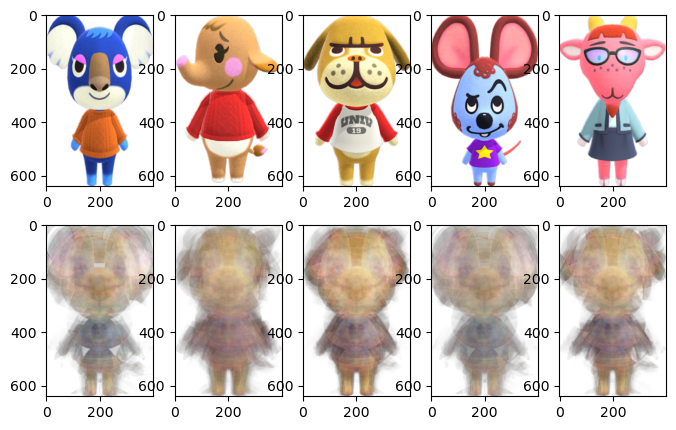

In [9]:
total = 5
plt.figure(figsize=(8, 5))

for i in range(total):
    
    # Original
    ax = plt.subplot(2, total, i+1)
    plt.imshow(X_test[i].reshape(height, width, 4))
    
    # Autoencoder result
    ax = plt.subplot(2, total, i+1+total)
    plt.imshow(decoded_imgs[i].reshape(height, width, 4))

plt.show()

### Some notes on the results

1. Using an encoding_dim value of 32 leads to a loss of 0.4498, and images that aren't so accurate
2. Using an encoding_dim value of 64 leads to a loss of 0.4318 (binary_crossentropy) 

### Convolutional Autoencoder - Part 1

Using the tutorial from https://blog.keras.io/building-autoencoders-in-keras.html, 'Convolutional Autoencoders'

In [10]:
input_shape = (640, 400, 4)
inputs = Input(shape=input_shape)
latent_dim = 100
# encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

#more layers

encoded = MaxPooling2D((2, 2), padding='same')(x)
# flatten
x = Flatten()(encoded) # 80, 50, 8
# dense 
x = Dense(512)(x)
latent = Dense(latent_dim, name='latent')(x)

x = Dense(80*50*8)(latent)
# print(x.shape)
x = Reshape((80,50,8))(x)

# decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(4, (3, 3), activation='relu', padding='same')(x)

autoencoder = Model(inputs, decoded)

print(autoencoder.summary())
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 640, 400, 4)]     0         
                                                                 
 conv2d (Conv2D)             (None, 640, 400, 16)      592       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 320, 200, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 320, 200, 8)       1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 160, 100, 8)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 160, 100, 8)       584 

In [11]:
X_train = X_train.reshape((len(X_train), 640, 400, 4))
X_test = X_test.reshape((len(X_test), 640, 400, 4))

print(X_train.shape)
print(X_test.shape)

(313, 640, 400, 4)
(79, 640, 400, 4)


In [12]:
epochs=50
batch_size=128

autoencoder.fit(X_train, X_train, epochs=epochs, 
                batch_size=batch_size, shuffle=True,
               validation_data=(X_test, X_test))

Epoch 1/50
3/3 [==============================] - 8s 2s/step - loss: 4.0174 - val_loss: 1.9023
Epoch 2/50
3/3 [==============================] - 7s 2s/step - loss: 1.4774 - val_loss: 0.8254
Epoch 3/50
3/3 [==============================] - 7s 2s/step - loss: 0.7470 - val_loss: 0.6264
Epoch 4/50
3/3 [==============================] - 7s 2s/step - loss: 0.6014 - val_loss: 0.5640
Epoch 5/50
3/3 [==============================] - 7s 2s/step - loss: 0.5587 - val_loss: 0.5775
Epoch 6/50
3/3 [==============================] - 7s 2s/step - loss: 0.5879 - val_loss: 0.5320
Epoch 7/50
3/3 [==============================] - 7s 2s/step - loss: 0.5825 - val_loss: 0.7239
Epoch 8/50
3/3 [==============================] - 7s 2s/step - loss: 0.6548 - val_loss: 0.5454
Epoch 9/50
3/3 [==============================] - 7s 2s/step - loss: 0.5698 - val_loss: 0.5356
Epoch 10/50
3/3 [==============================] - 7s 2s/step - loss: 0.5470 - val_loss: 0.5342
Epoch 11/50
3/3 [==============================] 

In [13]:
print(X_test.shape)
print(encoded_imgs.shape)
predictions = autoencoder.predict(X_test)

(79, 640, 400, 4)
(79, 64)
3/3 [==============================] - 1s 172ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


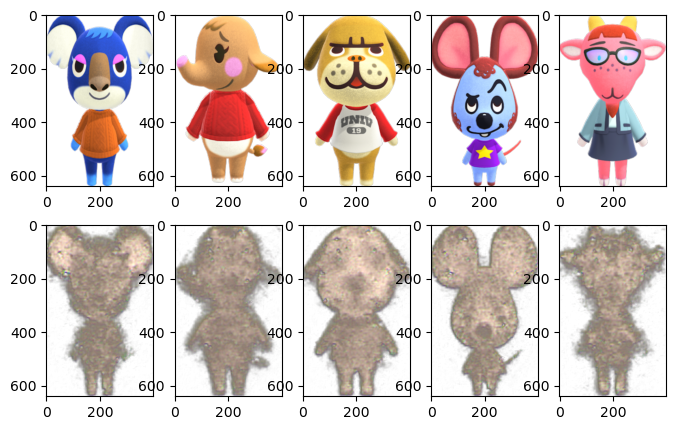

In [14]:
total = 5
plt.figure(figsize=(8, 5))

for i in range(total):
    
    # Original
    ax = plt.subplot(2, total, i+1)
    plt.imshow(X_test[i].reshape(height, width, 4))
    
    # Autoencoder result
    ax = plt.subplot(2, total, i+1+total)
    plt.imshow(predictions[i].reshape(height, width, 4))

plt.show()

### Convolutional autoencoder - part 2

Adding extra layers of Conv2D and MaxPooling, and Flatten()


In [15]:
input_shape = (640, 400, 4)
inputs = Input(shape=input_shape)

# encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

encoded = MaxPooling2D((2, 2), padding='same')(x)
flatten = Flatten()(encoded)

# decoder
#print(int(input_shape[0]/8) * int(input_shape[1]/8) * 8)
x = Dense(int(input_shape[0]/8) * int(input_shape[1]/8) * 8)(flatten)
x = Reshape((int(input_shape[0]/8) * int(input_shape[1]/8), 8))(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(4, (3, 3), activation='relu', padding='same')(x)

autoencoder = Model(inputs, decoded)

print(autoencoder.summary())
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 640, 400, 4)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 640, 400, 16)      592       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 320, 200, 16)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 320, 200, 8)       1160      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 160, 100, 8)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 160, 100, 8)       584 

In [16]:
X_train = X_train.reshape((len(X_train), 640, 400, 4))
X_test = X_test.reshape((len(X_test), 640, 400, 4))

print(X_train.shape)
print(X_test.shape)

epochs=25
batch_size=128

autoencoder.fit(X_train, X_train, epochs=epochs, 
                batch_size=batch_size, shuffle=True,
               validation_data=(X_test, X_test))


(313, 640, 400, 4)
(79, 640, 400, 4)
Epoch 1/25
3/3 [==============================] - 10s 3s/step - loss: 5.8075 - val_loss: 5.7904
Epoch 2/25
3/3 [==============================] - 8s 2s/step - loss: 5.4222 - val_loss: 4.1746
Epoch 3/25
3/3 [==============================] - 8s 3s/step - loss: 3.4171 - val_loss: 2.7173
Epoch 4/25
3/3 [==============================] - 8s 2s/step - loss: 2.5972 - val_loss: 2.5484
Epoch 5/25
3/3 [==============================] - 9s 3s/step - loss: 2.4230 - val_loss: 2.3865
Epoch 6/25
3/3 [==============================] - 7s 2s/step - loss: 2.2737 - val_loss: 2.2361
Epoch 7/25
3/3 [==============================] - 8s 2s/step - loss: 2.1251 - val_loss: 2.0556
Epoch 8/25
3/3 [==============================] - 7s 2s/step - loss: 1.7680 - val_loss: 0.9613
Epoch 9/25
3/3 [==============================] - 8s 2s/step - loss: 0.8961 - val_loss: 0.8030
Epoch 10/25
3/3 [==============================] - 7s 2s/step - loss: 0.7606 - val_loss: 0.6862
Epoch 11/25

In [17]:
print(X_test.shape)
print(encoded_imgs.shape)
predictions = autoencoder.predict(X_test)

(79, 640, 400, 4)
(79, 64)
3/3 [==============================] - 0s 129ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


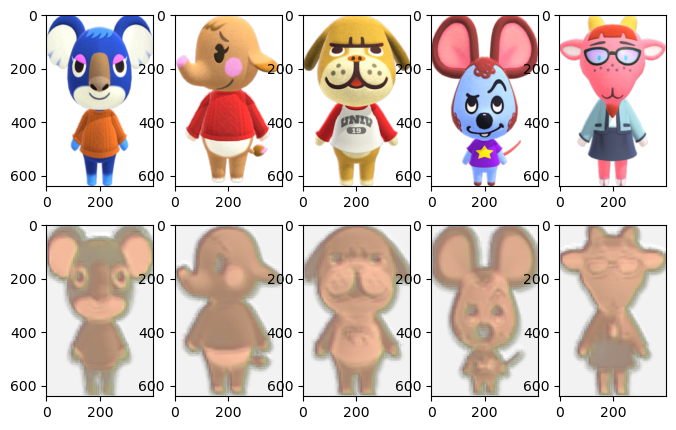

In [18]:
total = 5
plt.figure(figsize=(8, 5))

for i in range(total):
    
    # Original
    ax = plt.subplot(2, total, i+1)
    plt.imshow(X_test[i].reshape(height, width, 4))
    
    # Autoencoder result
    ax = plt.subplot(2, total, i+1+total)
    plt.imshow(predictions[i].reshape(height, width, 4))

plt.show()

### Variational autoencoder 

Using tutorial https://blog.keras.io/building-autoencoders-in-keras.html, 'Variational autoencoder (VAE)' and notebook ConvolutionalVAE from week 4

Algorithm tailored to the image data with the help of ChatGPT 

In [29]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [30]:
original_dim = 640 * 400 * 4
intermediate_dim = 64
latent_dim = 2

inputs = Input(shape=(original_dim,))
flattened = Flatten()(inputs)
h = Dense(intermediate_dim, activation='relu')(flattened)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

z = Lambda(sampling)([z_mean, z_log_sigma])

In [31]:
# encoder
encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)

#help from ChatGPT
#x = Dense(original_dim, activation='relu')(x)
#outputs = Reshape((640,400,4))(x)


outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

vae.summary()

print(inputs.shape)
print(outputs.shape)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1024000)]         0         
                                                                 
 encoder (Functional)        [(None, 2),               65536324  
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 1024000)           66560192  
                                                                 
Total params: 132,096,516
Trainable params: 132,096,516
Non-trainable params: 0
_________________________________________________________________
(None, 1024000)
(None, 1024000)


In [32]:
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
adam_optimizer = optimizers.Adam(learning_rate=0.0001)
vae.compile(optimizer=adam_optimizer)

In [33]:
print(X_train.shape)

X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))


print(X_train.shape)

(313, 1024000)
(313, 1024000)


In [34]:
epochs = 50
batch_size = 16
vae.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, 
        validation_data=(X_test, X_test))

Epoch 1/50
20/20 [==============================] - 3s 139ms/step - loss: 695486.7500 - val_loss: 641844.4375
Epoch 2/50
20/20 [==============================] - 3s 133ms/step - loss: 618180.3125 - val_loss: 592387.1875
Epoch 3/50
20/20 [==============================] - 3s 133ms/step - loss: 579264.0000 - val_loss: 563500.5000
Epoch 4/50
20/20 [==============================] - 3s 135ms/step - loss: 554888.0625 - val_loss: 540513.6875
Epoch 5/50
20/20 [==============================] - 3s 133ms/step - loss: 536041.6250 - val_loss: 524516.2500
Epoch 6/50
20/20 [==============================] - 3s 132ms/step - loss: 523002.7500 - val_loss: 514177.4375
Epoch 7/50
20/20 [==============================] - 3s 133ms/step - loss: 512676.7500 - val_loss: 506161.4375
Epoch 8/50
20/20 [==============================] - 3s 132ms/step - loss: 504645.2500 - val_loss: 499514.0000
Epoch 9/50
20/20 [==============================] - 3s 133ms/step - loss: 498959.1875 - val_loss: 494732.9062
Epoch 10/5

In [35]:
print(X_test.shape)
print(encoded_imgs.shape)
predictions = vae.predict(X_test)

(79, 1024000)
(79, 64)
3/3 [==============================] - 0s 90ms/step


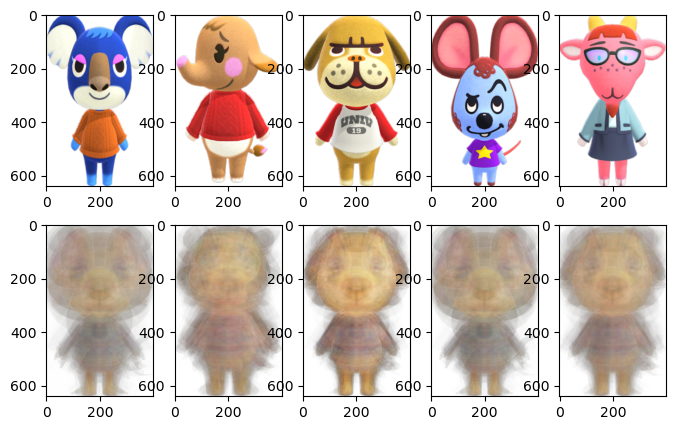

In [36]:
total = 5
plt.figure(figsize=(8, 5))

for i in range(total):
    
    # Original
    ax = plt.subplot(2, total, i+1)
    plt.imshow(X_test[i].reshape(height, width, 4))
    
    # Autoencoder result
    ax = plt.subplot(2, total, i+1+total)
    plt.imshow(predictions[i].reshape(height, width, 4))

plt.show()

### Inspecting latent vector space

Using the notebook from week4 - ConvolutionalVAE and help from ChatGPT 

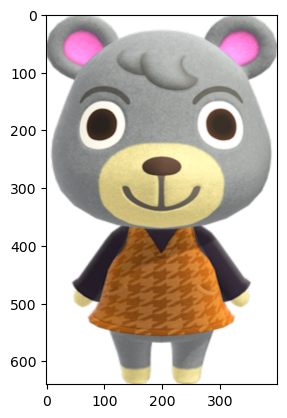

In [77]:
index = 54
test_img = X_test[index]
test_img_arr = np.asarray([test_img])

plt.imshow(test_img.reshape(height, width, 4))

(1, 1024000)
1/1 [==============================] - 0s 32ms/step
(1, 2)
[[-20.563951  71.485054]]


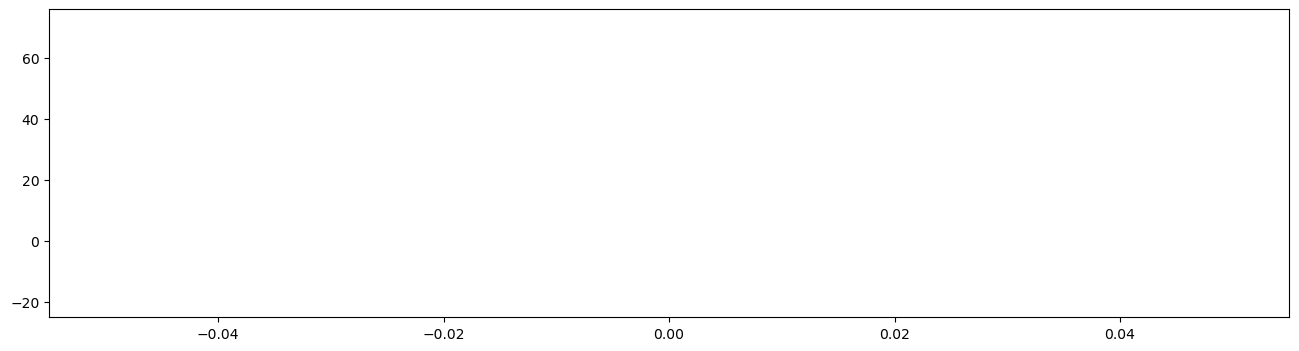

In [86]:
print(test_img.shape)

test_img = np.reshape(test_img, (1, original_dim))
encoder_result = encoder.predict(test_img)
latent_vector = encoder_result[-1]
print(latent_vector.shape)

print(latent_vector)

plt.figure(figsize=(16,4))
plt.plot(latent_vector)
plt.show()


1/1 [==============================] - 0s 101ms/step
(1, 1024000)


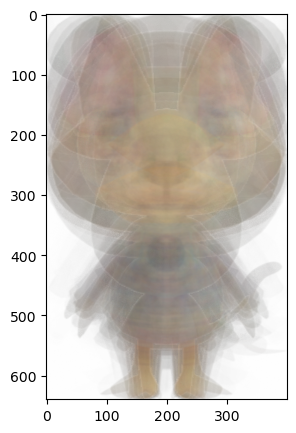

In [82]:
# Decoder

decoder_img = decoder.predict(latent_vector)
print(decoder_img.shape) #this is (79,1024000)
plt.figure(figsize=(8,5))
plt.imshow(decoder_img.reshape(640,400,4))           